This is code is meant to be used for the creation and training of a GAN for the Custom Made Ferris dataset. Heavy inspiration for the DCGAN was taken from https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html pytorch documentation. 

In [12]:
import os
import sys

import numpy as np
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as dset
import torchvision.utils as vutils
import matplotlib.pyplot as plt
from tqdm import tqdm
# Specifically Import My Dataset
from customDataset import FerrisAndBearsDataset as fb

In [13]:
# Variables
CUDA = False
batch_size = 128
img_chnl = 3
z = 100
hidden = 64
x = 64
epochs = 1000
lr = 2e-4
seed = 1

In [14]:
# Establish Device
CUDA = CUDA and torch.cuda.is_available()
print("PyTorch version: {}".format(torch.__version__))
if CUDA:
    print("CUDA version: {}\n".format(torch.version.cuda))

if CUDA:
    torch.cuda.manual_seed(seed)
device = torch.device("cuda:0" if CUDA else "cpu")
cudnn.benchmark = True

PyTorch version: 1.13.0


In [15]:
# Import Custom Dataset and Preproccess 
dataset = fb(csv_file = 'flipped.csv', root_dir = './Flipped', transform = transforms.Compose([
                     transforms.ToTensor(),
                     transforms.Normalize((0.5,), (0.5,)),
                     ]))
train_set = dataset
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)

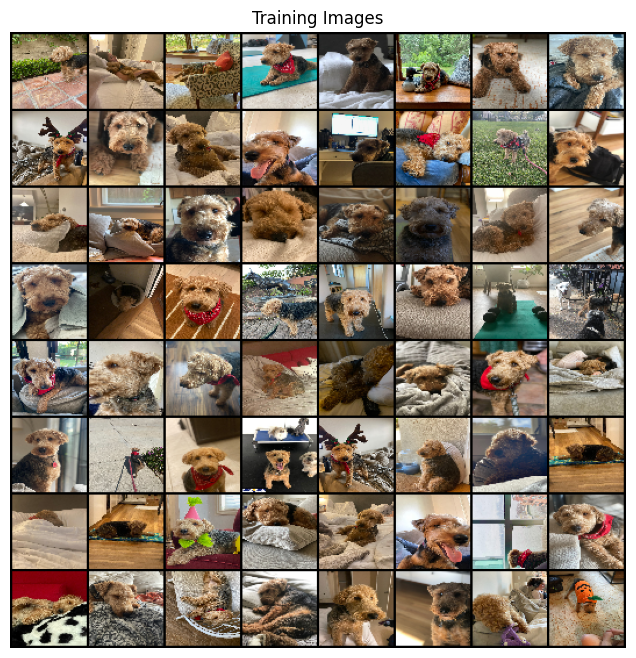

In [16]:
# Training images
real_batch = next(iter(train_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [17]:
# Initialize weights for training 
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [18]:
# Write Generator Network in Standard DCGAN for LSUN form
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(z, hidden * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(hidden * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(hidden * 8, hidden * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hidden * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(hidden * 4, hidden * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hidden * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(hidden * 2, hidden, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hidden),
            nn.ReLU(True),
            nn.ConvTranspose2d(hidden, img_chnl, 4, 2, 1, bias=False),
            nn.Tanh()
        )
    def forward(self, input):
        return self.main(input)

In [19]:
# Write Descriminator Network in Standard DCGAN for LSUN form
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(img_chnl, hidden, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(hidden, hidden * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hidden * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(hidden * 2, hidden * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hidden * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(hidden * 4, hidden * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hidden * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(hidden * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
    def forward(self, input):
        return self.main(input).view(-1, 1).squeeze(1)

In [20]:
# Create the generator
generator = Generator().to(device)
generator.apply(weights_init)
print(generator)

# Create the discriminator
descriminator = Discriminator().to(device)
descriminator.apply(weights_init)
print(descriminator)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [21]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that I will use to visualize the progression of the generator
noise = torch.randn(64, z, 1, 1, device=device)

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(descriminator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerG = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

In [23]:
# Training 
# Progress Vars
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
for epoch in range(epochs):
    for i, data in enumerate(train_loader, 0):
        # Descriminator Step
        descriminator.zero_grad()
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), 1, dtype=torch.float, device=device)
        output = descriminator(real_cpu).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # Classify
        noise = torch.randn(b_size, z, 1, 1, device=device)
        fake = generator(noise)
        label.fill_(0)
        output = descriminator(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        # Generator Step 
        generator.zero_grad()
        label.fill_(1)  
        output = descriminator(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        # Saving Output Info
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, epochs, i, len(train_loader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        G_losses.append(errG.item())
        D_losses.append(errD.item())

        if (iters % 500 == 0) or ((epoch == epochs-1) and (i == len(train_loader)-1)):
            with torch.no_grad():
                fake = generator(noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/1000][0/17]	Loss_D: 1.6417	Loss_G: 3.5597	D(x): 0.3811	D(G(z)): 0.3628 / 0.0367


KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(10,5))
plt.title("generatorand Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
real_batch = next(iter(train_loader))

# Real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

In [ ]:
# Save Model Progress
torch.save(descriminator, './descriminator')
torch.save(generator, './generator')